In [1]:
import itertools
import operator
import sys
import os
import numpy as np
from tqdm.notebook import tqdm
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt

In [2]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator"
checkpoint_name = "metrics_test.jsonl"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

1026


In [3]:
def expand(idx,chunk):
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]

  return []

experiments = []
for file in files:
    chunks = file.split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data["train_percentage"] = float(data["train_percentage"])*100 if data["train_percentage"] != "null" else 100.0

    if data["version"].startswith("v1.1."):
        experiments.append(data)



In [4]:
from collections import defaultdict


for experiment in tqdm(experiments):
    all_raw = []
    all_breakdown = defaultdict(dict)
    em = 0.0
    with open(experiment['file']) as f:
        for line in f:
            partial_results = json.loads(line)
            all_raw.extend(partial_results['test']['raw'])
            all_breakdown["breakdown_prop"].update(partial_results['test']['breakdown']["breakdown_prop"].items())
            all_breakdown["breakdown_type"].update(partial_results['test']['breakdown']["breakdown_type"].items())


    experiment["EM"] = np.mean([rec[2] for rec in all_raw])

    for k,v in all_breakdown["breakdown_prop"].items():
        experiment["prop_{}".format(k)] = np.mean(v)

    for k,v in all_breakdown["breakdown_type"].items():
        experiment["type_{}".format(k)] = np.mean(v)
        experiment["count_type_{}".format(k)] = len(v)


    experiment["raw"] = all_raw

    avg = []
    for k,v in experiment.items():
        if k.startswith("type_negative"):
            avg.append((experiment["count_{}".format(k)], v))

    support, ems = zip(*avg)
    experiment["x_avg_negative"] = np.average(a=ems,weights=support)

In [5]:
results = pd.DataFrame(experiments).fillna(0)
results = results[results["version"]=="v1.1.1"]
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("x_") or col.startswith("prop_") or col.startswith("type_"),results.columns)}
cols.update({col:[np.max] for col in filter(lambda col: col.startswith("count_type_negative"), results.columns)})
breakdown_cols = list(filter(lambda col: col.startswith("prop_"),results.columns))
type_cols = list(filter(lambda col: (col.startswith("type_") and "negative" not in col) or col.startswith("x"),results.columns))
print(type_cols)
type_cols2 = list(filter(lambda col: col.startswith("type_") and "negative" not in col or col == "x_avg_negative",results.columns))
type_cols3 = list(filter(lambda col: "count" not in col and  "negative" in col,results.columns))
type_cols4 = list(filter(lambda col: col.startswith("type_") and "negative" not in col,results.columns))
breakdown = pd.pivot_table(results, index=["experiment","version","model","lr","filters","train_percentage"],columns=[],aggfunc=cols)
breakdown

['type_argmin', 'type_count', 'type_set', 'type_bool', 'type_argmax', 'x_avg_negative']


EM  \
                                                                   mean   
experiment      version model   lr   filters train_percentage             
operator_filter v1.1.1  t5-base 1e-4 P19     100.0             0.964049   
                                     P19.P20 100.0             0.963579   
                                     P20     100.0             0.998679   
                                     P21     100.0             0.970515   
                                     P22     100.0             0.994562   
                                     P22.P23 100.0             0.994509   
                                     P23     100.0             0.999579   
                                     P26     100.0             0.999400   
                                     P27     100.0             0.944490   
                                     P35     100.0             0.999168   
                                     P38     100.0             0.999504   
                                     P47     100.0             0.945127   
                                     P50     100.0             0.998705   
                                     P54     100.0             0.996915   
                                     P57     100.0             0.997872   
                                     P6      100.0             0.997720   
operator_sweep  v1.1.1  t5-base 1e-5 null    0.5               0.070561   
                                             1.0               0.180238   
                                             5.0               0.774122   
                                             10.0              0.850059   
                                             50.0              0.999103   
                                             100.0             0.999516   
                                2e-5 null    0.5               0.178064   
                                             1.0               0.183763   
                                             5.0               0.727524   
                                             10.0              0.977371   
                                             50.0              0.999523   
                                             100.0             0.999535   
                                4e-5 null    0.5               0.230818   
                                             1.0               0.416857   
                                             5.0               0.974241   
                                             10.0              0.998616   
                                             50.0              0.999468   
                                             100.0             0.999497   
                                8e-5 null    0.5               0.283254   
                                             1.0               0.828910   
                                             5.0               0.998534   
                                             10.0              0.999205   
                                             50.0              0.999533   
                                             100.0             0.999574   
                                8e-6 null    0.5               0.062506   
                                             1.0               0.148525   
                                             5.0               0.548510   
                                             10.0              0.833747   
                                             50.0              0.998827   
                                             100.0             0.999476   

                                                                         \
                                                                    std   
experiment      version model   lr   filters train_percentage             
operator_filter v1.1.1  t5-base 1e-4 P19     100.0             0.011425   
                                     P19.P20 100.0             0.011362   
                  

In [6]:
display = "v1.1.1"

[1.0, 1.0, 1.0, 0.9999644873538511, 1.0, 0.9875476034664512, 0.9997173144876325, 0.99990995047276, 1.0, 1.0, 0.9993637327677625, 1.0, 1.0]
[0.0, 0.0, 0.0, 6.301214696031532e-05, 0.0, 0.001729282266607166, 0.0006321040219080682, 0.0002013568642503015, 0.0, 0.0, 0.0005808298594964453, 0.0, 0.0]


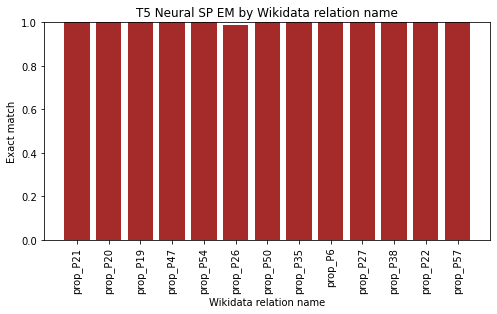

In [7]:

prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][100.0].T[breakdown_cols]

means = []
stds = []

for score in [prop_scores[a] for a in breakdown_cols]:
    means.append(score["mean"])
    stds.append(score["std"])

plt.figure(figsize=(8,4))
plt.xticks(rotation=90)
plt.title("T5 Neural SP EM by Wikidata relation name")
plt.ylabel("Exact match")
plt.xlabel("Wikidata relation name")

plt.bar(breakdown_cols,means,yerr=stds, color="brown")
plt.ylim(0,1)
print(means)
print(stds)
plt.savefig("/scratch/jth/neural_sp_rels.pdf", bbox_inches = 'tight')
plt.show()


[0.9999748892290994, 0.9999985045610886, 1.0, 0.9961926883990848, 0.999989466010723, 0.9998566282628177]
[5.6149390701304894e-05, 3.3439030619009824e-06, 0.0, 0.0004836646044891448, 9.96085287279914e-06, 0.00011218235806654739]


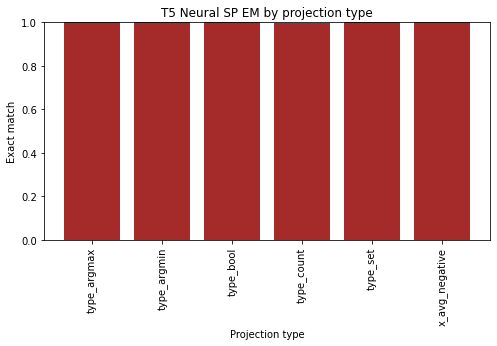

In [25]:
prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["1e-5"]["null"][100.0].T[type_cols]

means = []
stds = []

sort_cols = sorted(type_cols)
for score in [prop_scores[a] for a in sort_cols]:
    means.append(score["mean"])
    stds.append(score["std"])


plt.figure(figsize=(8,4))
plt.xticks(rotation=90)

plt.title("T5 Neural SP EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.bar(sort_cols,means,yerr=stds, color="brown")
plt.ylim(0,1)
print(means)
print(stds)
plt.savefig("/scratch/jth/neural_sp_proj.pdf", bbox_inches = 'tight')
plt.show()

In [72]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.title("T5 Operator model negative instance EM by negative type")

x = np.arange(len(type_cols2))
w = 0.2
plt.xticks(x+w/5, type_cols2,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

    means = []
    stds = []

    for score in [prop_scores[a] for a in type_cols2]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

plt.ylim(0,1)
plt.legend(datasets)
plt.show()

KeyError: 'null'

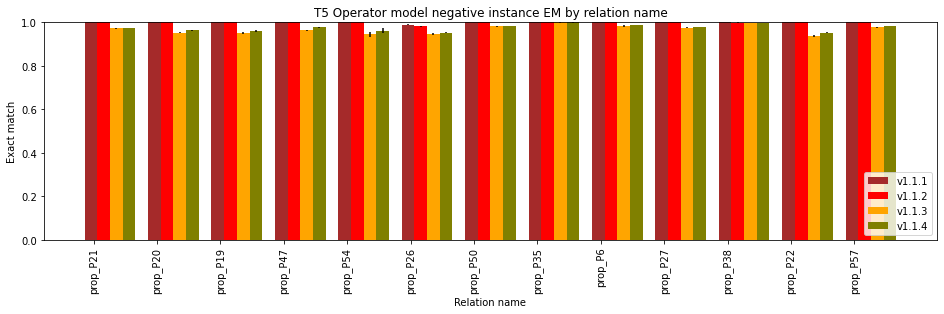

In [64]:

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by relation name")
plt.ylabel("Exact match")
plt.xlabel("Relation name")
plt.title("T5 Operator model negative instance EM by relation name")

x = np.arange(len(breakdown_cols))
w = 0.2
plt.xticks(x+w/5, breakdown_cols,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[breakdown_cols]

    means = []
    stds = []

    for score in [prop_scores[a] for a in breakdown_cols]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

print(means)
plt.ylim(0,1)
plt.legend(datasets, loc='lower right')
plt.show()


In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")


prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

means = []
stds = []

for score in [prop_scores[a] for a in type_cols2]:
    means.append(score["mean"])
    stds.append(score["std"])

plt.bar(type_cols2,means,yerr=stds)

plt.ylim(0,1)
plt.show()




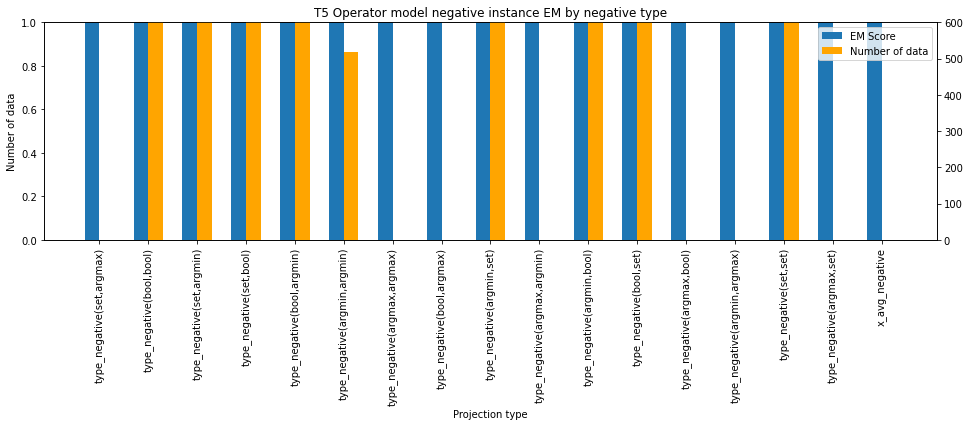

In [12]:
prop_scores = breakdown.T["operator_sweep"]["t5-base"]["null"][100.0].T[type_cols3]

means = []
stds = []
matched = []
props = []

w = 0.3
for name in type_cols3:

    try:
        score =  prop_scores[name]
        matched.append(name)
        means.append(score["mean"])
        stds.append(score["std"])

    except:
        print("No instances for {}".format(name))

    if "x" not in name:
        props.append(breakdown.T["operator_sweep"]["t5-base"]["null"][100.0]["count_{}".format(name)]["amax"])
    else:
        props.append(0.0)


fig,ax1 = plt.subplots(figsize=(16,4))

x = np.arange(len(matched))

plt.xticks(x+w/2, matched,rotation=90)
plt.title("T5 Operator model negative instance EM by negative type")
ax1.set_ylabel("Exact match")
ax1.set_xlabel("Projection type")

ems = ax1.bar(x, means, yerr=stds, width=w)

ax2 = plt.twinx()
sizes = ax2.bar(x+w, props, color="orange", width=w)
ax1.set_ylabel("Number of data")

plt.legend([ems,sizes],['EM Score','Number of data'])
ax1.set_ylim(0,1)
ax2.set_ylim(0,600)
plt.show()

['prop_P21', 'prop_P20', 'prop_P19', 'prop_P47', 'prop_P54', 'prop_P26', 'prop_P50', 'prop_P35', 'prop_P6', 'prop_P38', 'prop_P22', 'prop_P57']


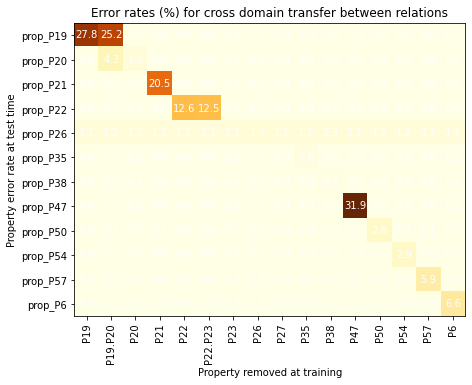

In [51]:
breakdown_cols= list(filter(lambda col: col!= "P27" and col!="prop_P27",breakdown_cols))
print(breakdown_cols)
cols2 = list(set(map(lambda a: a[0], filter(lambda col:col[0] != "null", breakdown.T["operator_filter"]["v1.1.1"]["t5-base"]["1e-4"].columns))))

x_labels = sorted(cols2)
y_labels = sorted(breakdown_cols)

heatmap = []

for c in y_labels:
    row = []
    for x in x_labels:
        row.append(breakdown.T["operator_filter"]["v1.1.1"]["t5-base"]["1e-4"][x][100.0].T[c]["mean"])
    heatmap.append(row)

heatmap=np.array(heatmap)

assert heatmap.shape[0] == len(y_labels)
assert heatmap.shape[1] == len(x_labels)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(1-heatmap, cmap="YlOrBr")

fig.tight_layout()
plt.xticks(np.arange(len(x_labels)),x_labels,rotation=90)
plt.yticks(np.arange(len(y_labels)),y_labels)

for j in range(len(x_labels)):
    for i in range(len(y_labels)):
        text = ax.text(j,i, round(100*(1-heatmap[i,j]),1),color='w', ha="center",va="center")


plt.xlabel("Property removed at training")
plt.ylabel("Property error rate at test time")
plt.title("Error rates (%) for cross domain transfer between relations")
plt.savefig("/scratch/jth/neural_sp_trans.pdf", bbox_inches = 'tight')
plt.show()


[0.5, 1.0, 5.0, 10.0, 50.0]
Float64Index([0.5, 1.0, 5.0, 10.0, 50.0], dtype='float64', name='train_percentage')


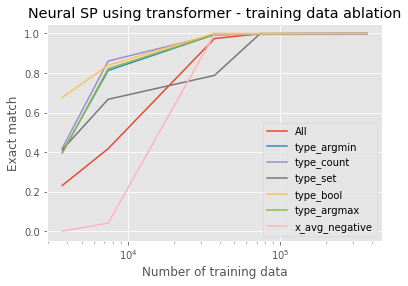

In [23]:
import matplotlib.pyplot as plt
with plt.style.context("ggplot"):
    sizes = [a[5] for a in breakdown.index if a[3] == "4e-5" and a[4] == "null" and a[5] != "null"][:-1]
    print(sizes)

    prop_scores = breakdown.T["operator_sweep"]["v1.1.1"]["t5-base"]["4e-5"]["null"][sizes].T["EM"]

    means = []
    uppers = []
    lowers = []
    print(prop_scores.index)

    for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
        means.append(mean)
        std = np.std(std)
        lowers.append(mean-std)
        uppers.append(mean-std)


    plt.figure(figsize=(6,4))

    actual = [739788*size/100 for size in sizes]
    plt.title("Neural SP using transformer - training data ablation")
    plt.ylabel("Exact match")
    plt.xlabel("Number of training data")

    plt.plot(actual,means)
    plt.fill_between(actual,lowers,uppers,alpha=0.2)
    plt.xscale("log")


    legend = ["All"]
    for line in type_cols2:
         prop_scores = breakdown.T["operator_sweep"]["v1.1.1"]["t5-base"]["4e-5"]["null"][sizes].T[line]
         means = []
         uppers = []
         lowers = []

         for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
             means.append(mean)
             lowers.append(mean-std)
             uppers.append(mean-std)


         plt.plot(actual,means)
         plt.fill_between(actual,lowers,uppers,alpha=0.2)
         legend.append(line)



    plt.legend(legend)
    plt.savefig("/scratch/jth/neural_sp_data.pdf", bbox_inches = 'tight')
    plt.show()


In [ ]:
    def get_num(item):
        bits = item.split("[SEP]")
        if len(bits) > 1:
            return bits[1].strip()
        else:
            return None

    def get_ent(item):
        bits = item.split("[SEP]")
        if len(bits) > 1:
            return bits[0].strip().replace("[LOOKUP]","").strip()
        else:
            return None

    err_predict_null =0
    err_wrong_num = 0
    err_wrong_ent = 0

    for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"], experiments):
        for item in exp["raw"]:
            if "[SEP]" in item[0]:
                master = get_num(item[0])
                predicted = get_num(item[1])

                if predicted is None:
                    err_predict_null += 1

                elif predicted != master:
                    err_wrong_num += 1

                    print(predicted,master)

            if "[SEP]" in item[0]:
                master = get_ent(item[0])
                predicted = get_ent(item[1])

                if predicted is None:
                    pass
                elif predicted != master:
                    err_wrong_num += 1
                    print(predicted,master)


    print(err_wrong_num, err_predict_null)

In [8]:
from collections import defaultdict
full = list(filter(lambda file: "filters=null,train_percentage=1.0" in file and "v1.0.1" in file, files))

print("FALSE NEGATIVES")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v1.1.4" in file, experiments):
    for item in exp["raw"]:
    # for item in random.sample(exp["raw"],k=100):
        if "[NULL_ANSWER]" in item[0] and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            #print("*"*80)
            #print("Score\t\t",item[2])
            #print("Query\t\t",item[3]["query"])
            #print("Fact\t\t",item[3]["fact"])
            #print("Projection\t\t",item[3]["projection"])
            ##print("Projection (tokenized)\t\t", item[1])
            #print("Predicted (tokenized)\t\t", item[0])

print(type_counts)

FALSE NEGATIVES
defaultdict(<class 'int'>, {})


In [6]:
import random
from collections import defaultdict
full = list(filter(lambda file: "filters=null,train_percentage=1.0" in file and "v1.0.1" in file, files))

print("FALSE POSITIVES")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v1.1.4" in exp["file"], experiments):
    for item in random.sample(exp["raw"],k=100):
        if "[NULL_ANSWER]" in item[1] and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            print("*"*80)
            print("Score\t\t",item[2])
            print("Query\t\t",item[3]["query"])
            print("Type\t\t",item[3]["type"])
            print("Fact\t\t",item[3]["fact"])
            print("Projection\t\t",item[3]["projection"])
            print("Projection (tokenized)\t\t", item[1])
            print("Predicted (tokenized)\t\t", item[0])
            break


print(type_counts)

FALSE POSITIVES
defaultdict(<class 'int'>, {})


In [1]:
import random
from collections import defaultdict

print("TRANS ERROR")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v1.1.4" in exp["file"], experiments):
    for item in exp["raw"]:
        if item[1]!= "[NULL_ANSWER]" and item[0] != "[NULL_ANSWER]" and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            print("*"*80)
            print("Score\t\t",item[2])
            print("Query\t\t",item[3]["query"])
            print("Type\t\t",item[3]["type"])
            print("Fact\t\t",item[3]["fact"])
            print("Projection\t\t",item[3]["projection"])
            print("Projection (tokenized)\t\t", item[1])
            print("Actual (tokenized)\t\t", item[0])
            break

    break

print(type_counts)


TRANS ERROR


NameError: name 'experiments' is not defined